**Task 2:**

As highlighted in the problem statement, one of the critical areas of focus for ParTech is to understand customer engagement better. The first step towards understanding engagement is to establish a clear and robust definition of the metric. The challenge is, there are no fixed definitions of engagement, and it often needs to be customized based on a company’s business requirements.

Through the following sub-tasks, Data Scientists need to build a metric that can help identify engaged users and differentiate between engaged and unengaged users. The approach needs to be backed with necessary business justification, visualizations, rationale, and/or modeling techniques.

In [ ]:
from google.colab import drive 
#get drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.cm as cm
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as shc
from sklearn.neighbors.nearest_centroid import NearestCentroid
import matplotlib.pyplot as plt



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.nearest_centroid module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
mmd_df=pd.read_csv('/content/drive/My Drive/Data_Science/All Modules/11 Industry Grade Project/Industry_Project_2/1028_Industry Project 2_Datasets/marketing_monthly_data.csv')
tdd_df=pd.read_csv('/content/drive/My Drive/Data_Science/All Modules/11 Industry Grade Project/Industry_Project_2/1028_Industry Project 2_Datasets/transaction_details_data.csv')
tmd_df=pd.read_csv('/content/drive/My Drive/Data_Science/All Modules/11 Industry Grade Project/Industry_Project_2/1028_Industry Project 2_Datasets/transaction_monthly_data.csv')

***Sub-tasks - Part A - [Data Handling using Jupyter Notebook | Python3]***
1. Convert the user_created_date and created_date columns from marketing_monthly_data & transaction_details_data datasets into usable datetime
formats (Hint: Use pandas package)
2. Considering 2018, as the observation time-period, what are the steps needed to create a new data frame, such that it satisfies all of the following criteria:
  *   Contains 1 record per customer
  *   Only COMPLETED transactions are considered
  *   Captures average 3-months behavior across the tenure of each customer along four engagement-specific dimensions, as stated below:
    1.   Number of transactions (Use count of amount_usd)
    2.   Total USD value of transactions (Use sum of amount_usd)
    3.   Total distinct types of transactions (Use transactions_type)
    4.   Total distinct days of transactions (Use created_date)

Hint:
*   2019 data to be used later for testing and experimentation
*   Tenure = 2018-12-31 23:59:59 UTC - min('user_created_date')
*   To calculate 3-months average across the tenure of each user, use group-by on user_id for each dimension, divide by tenure in days and then multiply by 90

In [ ]:
col_list = mmd_df['user_created_date'].tolist()
for i in range(len(col_list)):
  s=col_list[i]
  d = datetime.fromisoformat(s[:-1])
  col_list[i]=d.strftime('%Y-%m-%d %H:%M:%S')
mmd_df['user_created_date']=col_list
print(mmd_df['user_created_date'])

0         2018-01-13 05:15:15
1         2018-01-13 05:15:15
2         2018-01-13 05:15:15
3         2018-01-13 05:15:15
4         2018-01-13 05:15:15
                 ...         
143311    2018-08-13 01:21:23
143312    2018-08-13 01:21:23
143313    2018-08-13 01:21:23
143314    2018-08-13 01:21:23
143315    2018-08-13 01:21:23
Name: user_created_date, Length: 143316, dtype: object


In [ ]:
col_list1 = tdd_df['created_date'].tolist()
for i in range(len(col_list1)):
  s=col_list1[i]
  time=str(round(float(s.split(' ')[1].split(':')[2])))
  if(time=='60'):
    s=s.replace(s.split(' ')[1].split(':')[2],'00')
  else:
    s=s.replace(s.split(' ')[1].split(':')[2],time)
  #d = datetime.fromisoformat(s[:-1])
  col_list1[i]=datetime.strptime(s,'%Y-%m-%d %H:%M:%S')
tdd_df['created_date']=col_list1
print(tdd_df['created_date'])

0         2018-04-03 03:34:22
1         2019-03-19 06:15:00
2         2019-03-18 18:53:41
3         2019-03-22 14:20:02
4         2019-03-22 05:42:50
                  ...        
2740070   2019-04-30 10:10:37
2740071   2019-04-30 18:42:45
2740072   2019-05-01 11:34:25
2740073   2019-04-30 16:51:26
2740074   2019-05-01 06:01:59
Name: created_date, Length: 2740075, dtype: datetime64[ns]


In [ ]:
x=datetime.strptime('2018-12-31 23:59:59','%Y-%m-%d %H:%M:%S')
y=datetime.strptime(min(mmd_df['user_created_date']),'%Y-%m-%d %H:%M:%S')
tenure=str(x-y)

time_string = tenure.split(' ')[2]
pt = datetime.strptime(time_string,'%H:%M:%S')
sec_time = pt.second + pt.minute*60 + pt.hour*3600
sec_per_day=86400
sec_day=int(tenure.split(' ')[0])*sec_per_day
total_sec=sec_time+sec_day
month_3_sec=90*sec_per_day
ob_tenure=month_3_sec/total_sec

ob_df=tdd_df[['user_id','transactions_type','transactions_state','created_date','amount_usd']]
ob_df=ob_df[ob_df['transactions_state']=='COMPLETED']
df1=pd.DataFrame(ob_df.groupby('user_id')['amount_usd'].count())
df1.reset_index(inplace=True)
df2=pd.DataFrame(ob_df.groupby('user_id')['amount_usd'].sum())
df2.reset_index(inplace=True)
df3=pd.DataFrame(ob_df.groupby('user_id')['transactions_type'].nunique())
df3.reset_index(inplace=True)
df4=pd.DataFrame(ob_df.groupby('user_id')['created_date'].nunique())
df4.reset_index(inplace=True)
ob_df=pd.merge(df1, df2, on='user_id')
ob_df=pd.merge(ob_df, df3, on='user_id')
ob_df=pd.merge(ob_df, df4, on='user_id')
ob_df.rename(columns = {'amount_usd_x':'amount_usd_count', 'amount_usd_y':'amount_usd_sum', 'transactions_type':'total_unique_transactions_type', 'created_date':'total_unique_created_date'}, inplace = True)
ob_df['amount_usd_count'] = (ob_df['amount_usd_count']*ob_tenure).round(2)
ob_df['amount_usd_sum'] = (ob_df['amount_usd_sum']*ob_tenure).round(2)
ob_df['total_unique_transactions_type'] = (ob_df['total_unique_transactions_type']*ob_tenure).round(2)
ob_df['total_unique_created_date'] = (ob_df['total_unique_created_date']*ob_tenure).round(2)
print(ob_df.shape)
print(ob_df['user_id'].nunique())
print(ob_df.dtypes)

(18529, 5)
18529
user_id                            object
amount_usd_count                  float64
amount_usd_sum                    float64
total_unique_transactions_type    float64
total_unique_created_date         float64
dtype: object


***Sub-tasks - Part B - [Unsupervised Learning using Jupyter Notebook | Python3]***
1. Use two popular clustering algorithms, K-means & Hierarchical, to combine the four engagement-specific dimensions into a single multi-class metric (Note: Outliers may bias the clustering algorithms)
2. Compare the centroid values of the two clustering algorithms across each dimension in each cluster
3. Which of the two algorithms is a better choice for defining the engagement metric?
4. How may the centroid values from the optimal algorithm be used to define a business rule for tagging engaged vs. unengaged users?

Note: 

The above business-rule based engagement metric built on top of unsupervised modeling framework fits ParTech’s requirements (easy-to-understand, data intelligence, business value, and actionability-driven engagement metric). 

However, beyond the scope of this project, Data Scientists are encouraged to research further and explore other robust approaches in designing an engagement metric as well.

In [ ]:
eng_part1=mmd_df[['user_id','attributes_notifications_marketing_email','attributes_notifications_marketing_push','num_contacts','user_created_date']]
eng_part1['user_created_date']=eng_part1['user_created_date'].str.split(' ').str[0]
eng_part1['user_created_date']=pd.to_datetime(eng_part1['user_created_date'])
eng_part2=tdd_df[['user_id','created_date']]
eng_part2['created_date']=eng_part2['created_date'].astype(str)
eng_part2['created_date']=eng_part2['created_date'].str.split(' ').str[0]
eng_part2['created_date']=pd.to_datetime(eng_part2['created_date'])
eng=eng_part2.groupby(['user_id'])['created_date'].max()
eng_part2=pd.DataFrame(eng)
eng_part2.reset_index(inplace=True)
eng_df1=eng_part1.merge(eng_part2, left_on=['user_id'], right_on=['user_id'], how='left')
eng_df1=eng_df1.rename(columns={"created_date": "last_transact_date"})
eng_df1['engaged_days']=eng_df1['last_transact_date']-eng_df1['user_created_date']
eng_df1['engaged_days']=eng_df1['engaged_days'].astype(str)
eng_df1['engaged_days']=eng_df1['engaged_days'].str.split(' ').str[0]
eng_df1.loc[(eng_df1.engaged_days == 'NaT'),'engaged_days']=0
print(eng_df1.dtypes)
print(eng_df1.head())
print(eng_df1.to_csv('/content/drive/My Drive/Data_Science/All Modules/11 Industry Grade Project/Industry_Project_2/1028_Industry Project 2_Datasets/engaged.csv'))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

user_id                                             object
attributes_notifications_marketing_email           float64
attributes_notifications_marketing_push            float64
num_contacts                                         int64
user_created_date                           datetime64[ns]
last_transact_date                          datetime64[ns]
engaged_days                                        object
dtype: object
  user_id  ...  engaged_days
0     c_0  ...           474
1     c_0  ...           474
2     c_0  ...           474
3     c_0  ...           474
4     c_0  ...           474

[5 rows x 7 columns]
None


In [ ]:
eng_df1=eng_df1.fillna(0)
eng=eng_df1.groupby(['user_id','engaged_days'])['num_contacts'].sum()
part3=pd.DataFrame(eng)
part3.reset_index(level=[0,1], inplace=True)
part3['engaged_days']=part3['engaged_days'].astype('int')
eng_df1['count_email_accept'] = eng_df1['attributes_notifications_marketing_email'].values
eng_df1['count_email_reject'] = eng_df1['attributes_notifications_marketing_email'].values
eng_df1['count_push_accept'] = eng_df1['attributes_notifications_marketing_push'].values
eng_df1['count_push_reject'] = eng_df1['attributes_notifications_marketing_push'].values
part5=eng_df1[['user_id','count_email_accept','count_email_reject']]
part6=eng_df1[['user_id','count_push_accept','count_push_reject']]
accept =  part5['count_email_accept']==1.0
reject =  part5['count_email_reject']==0.0
part5_1 = part5[accept]
part5_1=part5_1.drop(['count_email_reject'], axis=1)
eng=part5_1.groupby(['user_id'])['count_email_accept'].count()
part5_1=pd.DataFrame(eng)
part5_1.reset_index(inplace=True)
part5_2 = part5[reject]
part5_2=part5_2.drop(['count_email_accept'], axis=1)
eng=part5_2.groupby(['user_id'])['count_email_reject'].count()
part5_2=pd.DataFrame(eng)
part5_2.reset_index(inplace=True)
accept =  part6['count_push_accept']==1.0
reject =  part6['count_push_reject']==0.0
part6_1 = part6[accept]
part6_1=part6_1.drop(['count_push_reject'], axis=1)
eng=part6_1.groupby(['user_id'])['count_push_accept'].count()
part6_1=pd.DataFrame(eng)
part6_1.reset_index(inplace=True)
part6_2 = part6[reject]
part6_2=part6_2.drop(['count_push_accept'], axis=1)
eng=part6_2.groupby(['user_id'])['count_push_reject'].count()
part6_2=pd.DataFrame(eng)
part6_2.reset_index(inplace=True)
part3=part3.merge(part5_1, left_on=['user_id'], right_on=['user_id'], how='left')
part3=part3.merge(part5_2, left_on=['user_id'], right_on=['user_id'], how='left')
part3=part3.merge(part6_1, left_on=['user_id'], right_on=['user_id'], how='left')
part3=part3.merge(part6_2, left_on=['user_id'], right_on=['user_id'], how='left')
part3=part3.fillna(0)
print(part3['user_id'].nunique())
print(part3.isnull().sum())
print(part3)

19370
user_id               0
engaged_days          0
num_contacts          0
count_email_accept    0
count_email_reject    0
count_push_accept     0
count_push_reject     0
dtype: int64
      user_id  engaged_days  ...  count_push_accept  count_push_reject
0         c_0           474  ...               17.0                0.0
1         c_1           393  ...                0.0               12.0
2        c_10           492  ...               17.0                0.0
3       c_100           477  ...                0.0               14.0
4      c_1000           171  ...               12.0                0.0
...       ...           ...  ...                ...                ...
19365  c_9995           251  ...                9.0                0.0
19366  c_9996           238  ...                9.0                0.0
19367  c_9997           250  ...                9.0                0.0
19368  c_9998            40  ...                4.0                0.0
19369  c_9999           265  ...

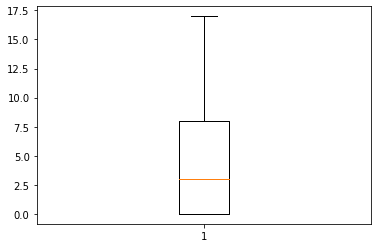

In [ ]:
plt.boxplot(part3.count_email_accept)
plt.show()
Q1 = part3.count_email_accept.quantile(0.25)
Q3 = part3.count_email_accept.quantile(0.75)
IQR = Q3 - Q1
part3 = part3[(part3.count_email_accept >= (Q1 - 1.5*IQR)) & (part3.count_email_accept <= (Q3 + 1.5*IQR))]

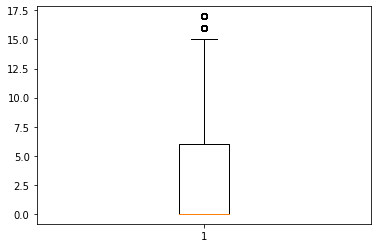

In [ ]:
plt.boxplot(part3.count_email_reject)
plt.show()
Q1 = part3.count_email_reject.quantile(0.25)
Q3 = part3.count_email_reject.quantile(0.75)
IQR = Q3 - Q1
part3 = part3[(part3.count_email_reject >= (Q1 - 1.5*IQR)) & (part3.count_email_reject <= (Q3 + 1.5*IQR))]

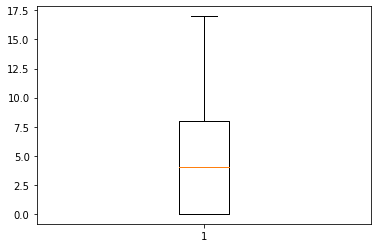

In [ ]:
plt.boxplot(part3.count_push_accept)
plt.show()
Q1 = part3.count_push_accept.quantile(0.25)
Q3 = part3.count_push_accept.quantile(0.75)
IQR = Q3 - Q1
part3 = part3[(part3.count_push_accept >= (Q1 - 1.5*IQR)) & (part3.count_push_accept <= (Q3 + 1.5*IQR))]

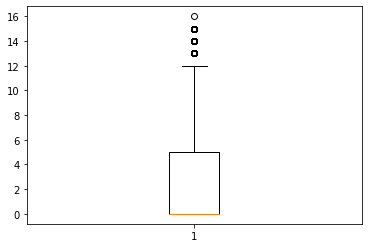

In [ ]:
plt.boxplot(part3.count_push_reject)
plt.show()
Q1 = part3.count_push_reject.quantile(0.25)
Q3 = part3.count_push_reject.quantile(0.75)
IQR = Q3 - Q1
part3 = part3[(part3.count_push_reject >= (Q1 - 1.5*IQR)) & (part3.count_push_reject <= (Q3 + 1.5*IQR))]

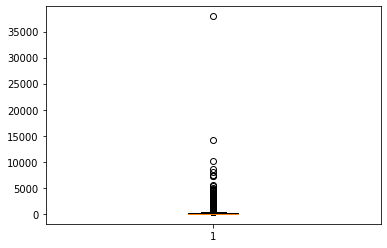

In [ ]:
plt.boxplot(part3.num_contacts)
plt.show()
Q1 = part3.num_contacts.quantile(0.25)
Q3 = part3.num_contacts.quantile(0.75)
IQR = Q3 - Q1
part3 = part3[(part3.num_contacts >= (Q1 - 1.5*IQR)) & (part3.num_contacts <= (Q3 + 1.5*IQR))]

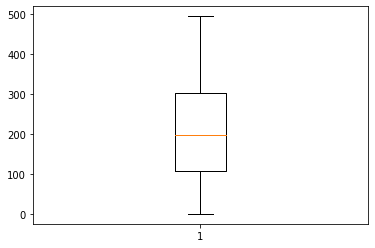

In [ ]:
plt.boxplot(part3.engaged_days)
plt.show()
Q1 = part3.engaged_days.quantile(0.25)
Q3 = part3.engaged_days.quantile(0.75)
IQR = Q3 - Q1
part3 = part3[(part3.engaged_days >= (Q1 - 1.5*IQR)) & (part3.engaged_days <= (Q3 + 1.5*IQR))]

In [ ]:
lb=LabelEncoder()
lb.fit(part3['user_id'])
part3['user_id']=lb.transform(part3['user_id'])
print(part3)

       user_id  engaged_days  ...  count_push_accept  count_push_reject
0            0           474  ...               17.0                0.0
1            1           393  ...                0.0               12.0
4            2           171  ...               12.0                0.0
6            3           175  ...                0.0                5.0
7            4           247  ...                0.0                9.0
...        ...           ...  ...                ...                ...
19364    16458           251  ...               10.0                0.0
19365    16459           251  ...                9.0                0.0
19366    16460           238  ...                9.0                0.0
19368    16461            40  ...                4.0                0.0
19369    16462           265  ...                0.0               10.0

[16463 rows x 7 columns]


In [ ]:
#Standardizing the features
S1=part3.drop(['user_id'], axis=1)
x1 = StandardScaler().fit_transform(S1)
pca = PCA(n_components=1)
principalComponents1 = pca.fit_transform(x1)
X = pd.DataFrame(data = principalComponents1, columns = ['principal_component_1'])
X['user_id']=X.index
print(X)

       principal_component_1  user_id
0                   3.910256        0
1                  -2.847832        1
2                   2.256445        2
3                  -1.701827        3
4                  -2.478336        4
...                      ...      ...
16458               1.984654    16458
16459               1.952409    16459
16460               1.771693    16460
16461               0.226191    16461
16462              -2.814493    16462

[16463 rows x 2 columns]


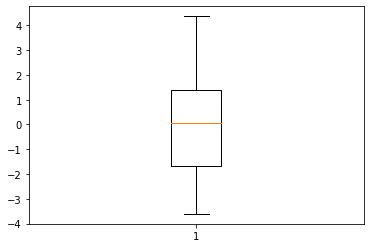

In [ ]:
plt.boxplot(X.principal_component_1)
plt.show()
Q1 = X.principal_component_1.quantile(0.25)
Q3 = X.principal_component_1.quantile(0.75)
IQR = Q3 - Q1
X = X[(X.principal_component_1 >= (Q1 - 1.5*IQR)) & (X.principal_component_1 <= (Q3 + 1.5*IQR))]

In [ ]:
wcss=[]
for i in range(1,11):
    kmeans = KMeans(n_clusters= i, init='k-means++', random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

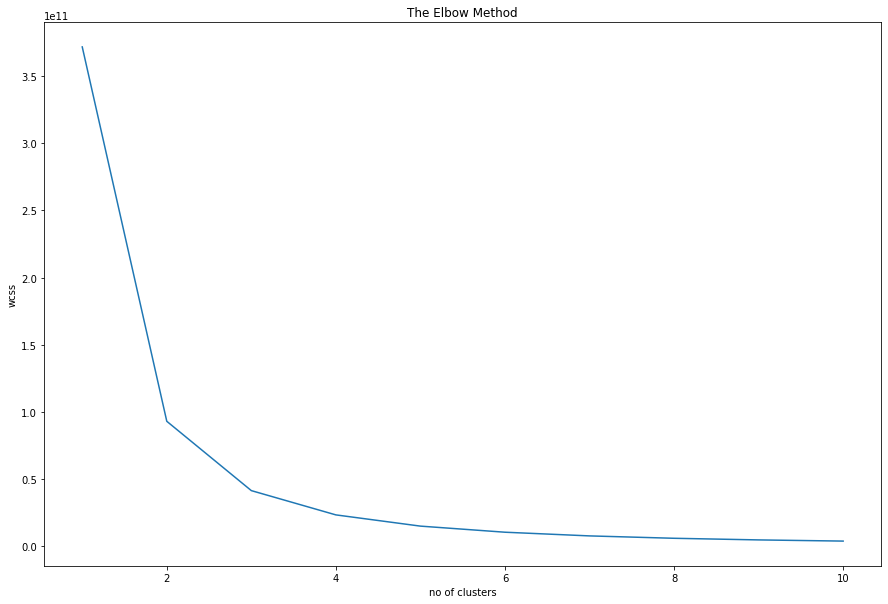

In [ ]:
plt.figure(figsize=(15,10))
plt.plot(range(1,11), wcss)
plt.title('The Elbow Method')
plt.xlabel('no of clusters')
plt.ylabel('wcss')
plt.show()

In [ ]:
#Build 3 clusters
kmeans = KMeans(n_clusters = 3, init = 'k-means++', random_state = 42)
y_kmeans = kmeans.fit_predict(X)
X["type"] = y_kmeans
sk_centroids = np.array(kmeans.cluster_centers_)
part4=part3.merge(X, left_on=['user_id'], right_on=['user_id'], how='left')
part4=part4.drop(['principal_component_1'], axis=1)
print(part4.columns)

Index(['user_id', 'engaged_days', 'num_contacts', 'count_email_accept',
       'count_email_reject', 'count_push_accept', 'count_push_reject', 'type'],
      dtype='object')


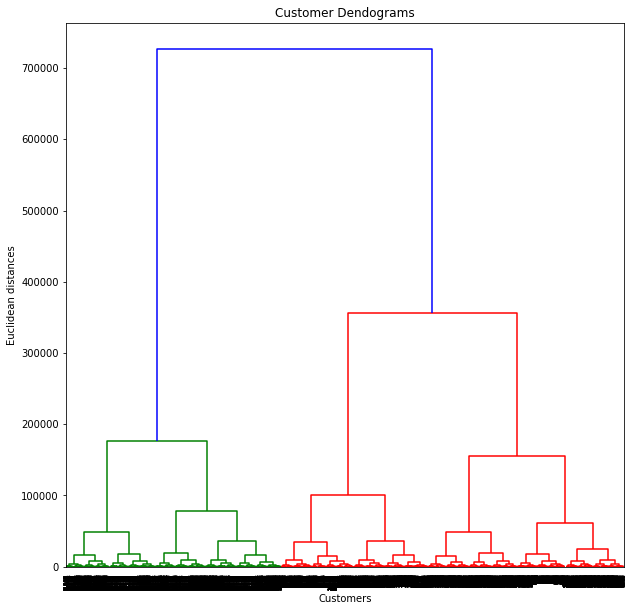

In [ ]:
plt.figure(figsize=(10, 10))
plt.title("Customer Dendograms")
dend = shc.dendrogram(shc.linkage(X, method='ward'))
plt.xlabel('Customers')
plt.ylabel('Euclidean distances')
plt.show()

In [ ]:
hcluster = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')
h_label = hcluster.fit_predict(X)
X["h_type"] = h_label
part5=part3.merge(X, left_on=['user_id'], right_on=['user_id'], how='left')
part5=part5.drop(['principal_component_1'], axis=1)
print(part5.columns)
clf = NearestCentroid()
clf.fit(X, h_label)
ak_centroids = clf.centroids_

Index(['user_id', 'engaged_days', 'num_contacts', 'count_email_accept',
       'count_email_reject', 'count_push_accept', 'count_push_reject', 'type',
       'h_type'],
      dtype='object')


In [ ]:
part5.to_csv('/content/drive/My Drive/Data_Science/All Modules/11 Industry Grade Project/Industry_Project_2/1028_Industry Project 2_Datasets/cluster_data.csv')

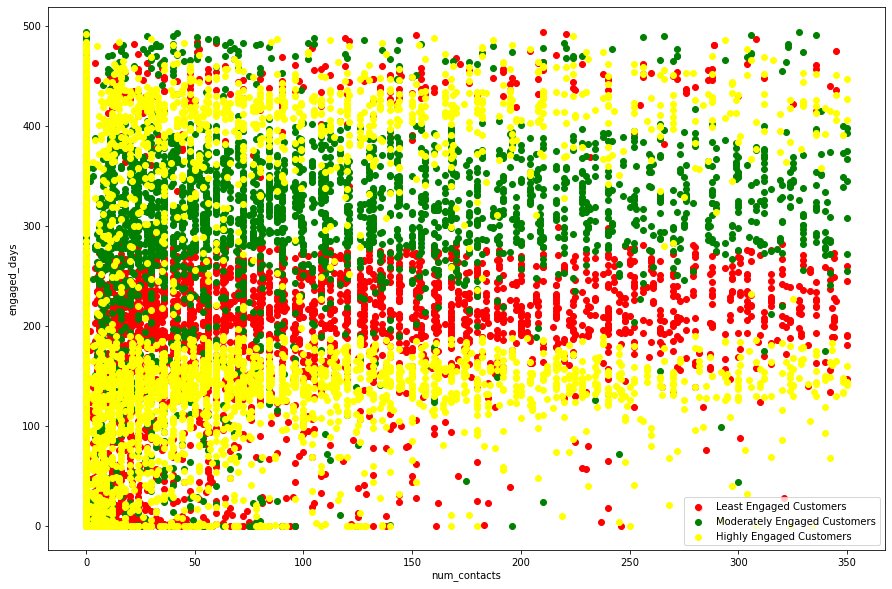

(0, array([-1.42476076e-01,  2.77450000e+03]))
(1, array([3.72995454e-01, 1.37495000e+04]))
(2, array([-2.24736853e-01,  8.29300000e+03]))


In [ ]:
plt.figure(figsize = (15, 10))
plt.scatter(part4["num_contacts"][part4["type"] == 0], part4["engaged_days"][part4["type"] == 0], color = "red", label = 'Least Engaged Customers')
plt.scatter(part4["num_contacts"][part4["type"] == 1], part4["engaged_days"][part4["type"] == 1], color = "green", label = 'Moderately Engaged Customers')
plt.scatter(part4["num_contacts"][part4["type"] == 2], part4["engaged_days"][part4["type"] == 2], color = "yellow", label = 'Highly Engaged Customers')
#plt.scatter(sk_centroids[:,0], sk_centroids[:,1], color = 'black')
plt.xlabel('num_contacts')
plt.ylabel('engaged_days')
plt.legend()
plt.show()
for centroid in enumerate(sk_centroids):
  print(centroid)
  #plt.scatter(centroid[0], centroid[1])


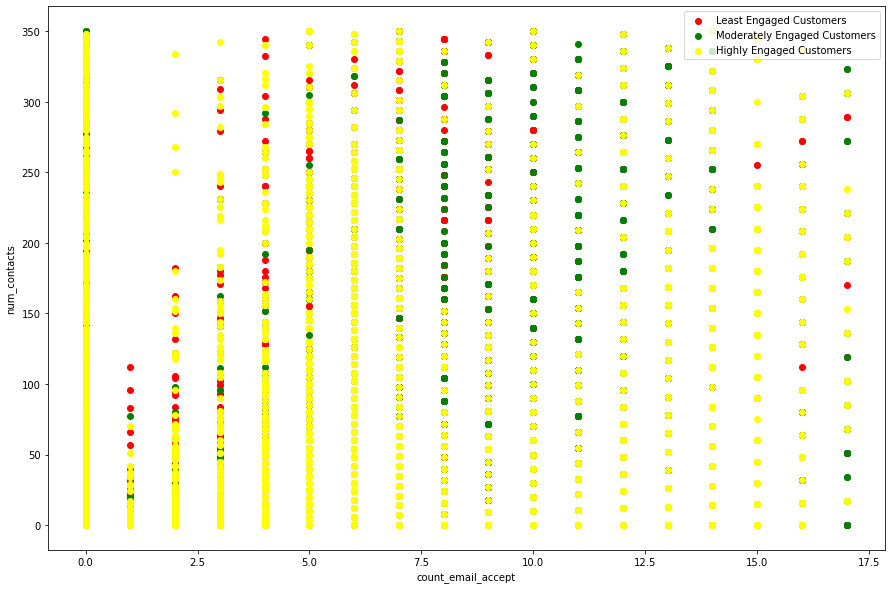

In [ ]:
plt.figure(figsize = (15, 10))
plt.scatter(part4["count_email_accept"][part4["type"] == 0], part4["num_contacts"][part4["type"] == 0], color = "red", label = 'Least Engaged Customers')
plt.scatter(part4["count_email_accept"][part4["type"] == 1], part4["num_contacts"][part4["type"] == 1], color = "green", label = 'Moderately Engaged Customers')
plt.scatter(part4["count_email_accept"][part4["type"] == 2], part4["num_contacts"][part4["type"] == 2], color = "yellow", label = 'Highly Engaged Customers')
plt.xlabel('count_email_accept')
plt.ylabel('num_contacts')
plt.legend()
plt.show()

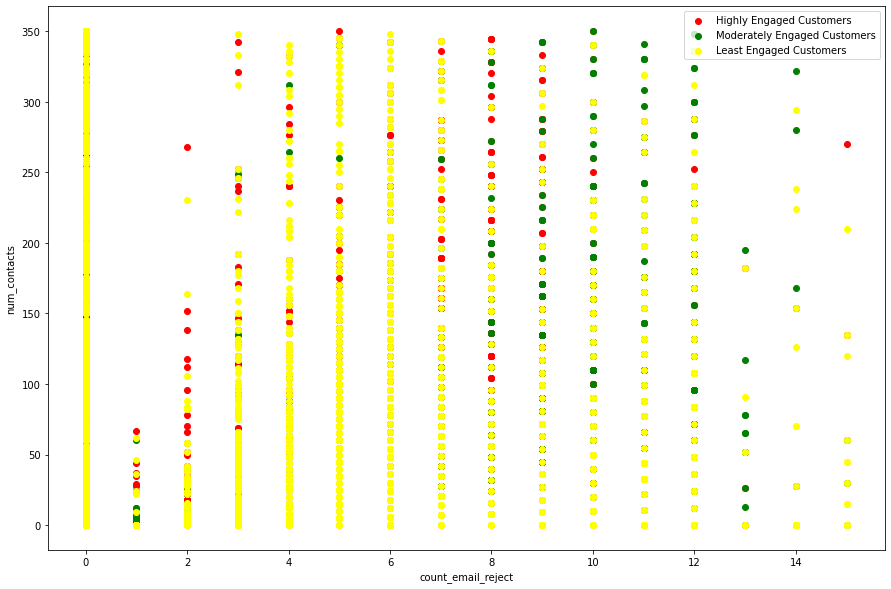

In [ ]:
plt.figure(figsize = (15, 10))
plt.scatter(part4["count_email_reject"][part4["type"] == 0], part4["num_contacts"][part4["type"] == 0], color = "red", label = 'Highly Engaged Customers')
plt.scatter(part4["count_email_reject"][part4["type"] == 1], part4["num_contacts"][part4["type"] == 1], color = "green", label = 'Moderately Engaged Customers')
plt.scatter(part4["count_email_reject"][part4["type"] == 2], part4["num_contacts"][part4["type"] == 2], color = "yellow", label = 'Least Engaged Customers')
plt.xlabel('count_email_reject')
plt.ylabel('num_contacts')
plt.legend()
plt.show()

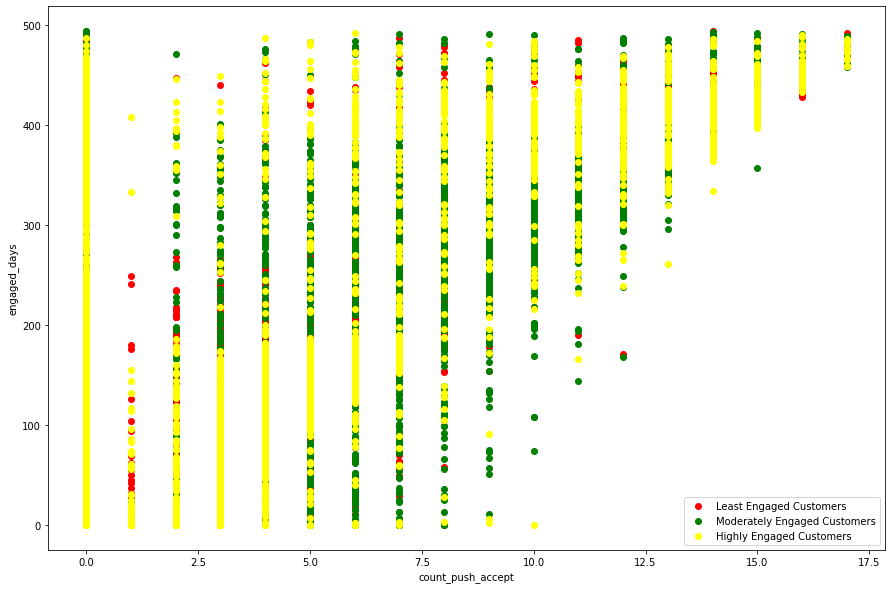

In [ ]:
plt.figure(figsize = (15, 10))
plt.scatter(part4["count_push_accept"][part4["type"] == 0], part4["engaged_days"][part4["type"] == 0], color = "red", label = 'Least Engaged Customers')
plt.scatter(part4["count_push_accept"][part4["type"] == 1], part4["engaged_days"][part4["type"] == 1], color = "green", label = 'Moderately Engaged Customers')
plt.scatter(part4["count_push_accept"][part4["type"] == 2], part4["engaged_days"][part4["type"] == 2], color = "yellow", label = 'Highly Engaged Customers')
plt.xlabel('count_push_accept')
plt.ylabel('engaged_days')
plt.legend()
plt.show()

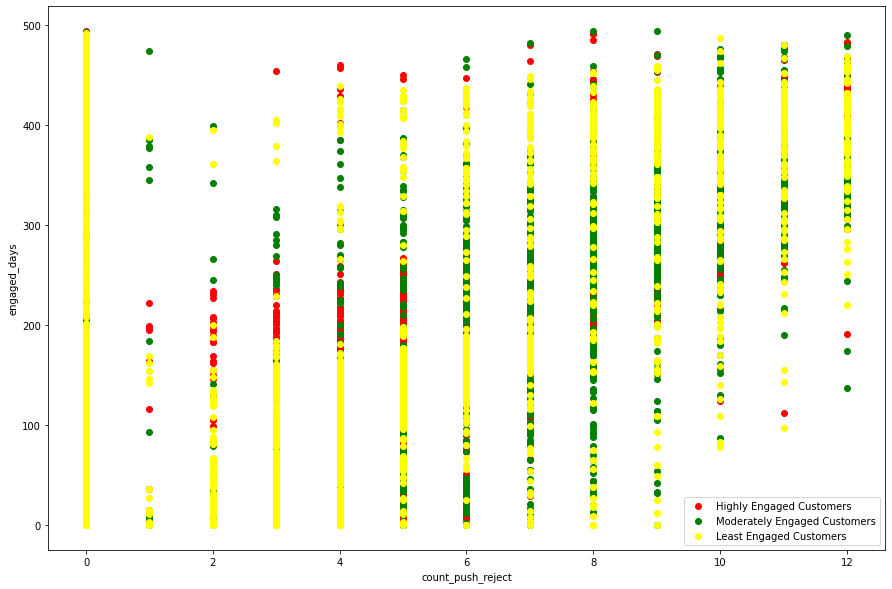

In [ ]:
plt.figure(figsize = (15, 10))
plt.scatter(part4["count_push_reject"][part4["type"] == 0], part4["engaged_days"][part4["type"] == 0], color = "red", label = 'Highly Engaged Customers')
plt.scatter(part4["count_push_reject"][part4["type"] == 1], part4["engaged_days"][part4["type"] == 1], color = "green", label = 'Moderately Engaged Customers')
plt.scatter(part4["count_push_reject"][part4["type"] == 2], part4["engaged_days"][part4["type"] == 2], color = "yellow", label = 'Least Engaged Customers')
plt.xlabel('count_push_reject')
plt.ylabel('engaged_days')
plt.legend()
plt.show()

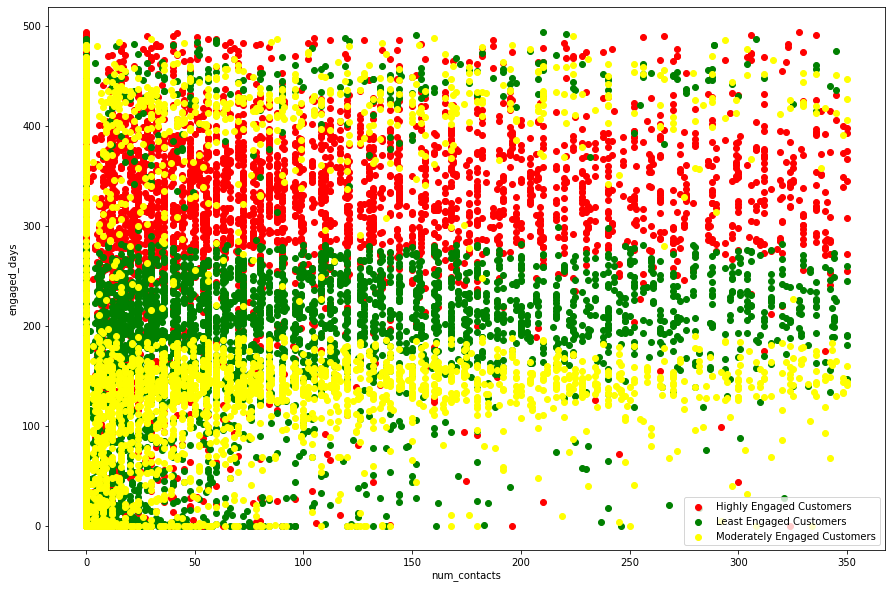

In [ ]:
plt.figure(figsize = (15, 10))
plt.scatter(part5["num_contacts"][part5["h_type"] == 0], part5["engaged_days"][part5["h_type"] == 0], color = "red", label = 'Highly Engaged Customers')
plt.scatter(part5["num_contacts"][part5["h_type"] == 1], part5["engaged_days"][part5["h_type"] == 1], color = "green", label = 'Least Engaged Customers')
plt.scatter(part5["num_contacts"][part5["h_type"] == 2], part5["engaged_days"][part5["h_type"] == 2], color = "yellow", label = 'Moderately Engaged Customers')
#plt.scatter(ak_centroids[:,0], ak_centroids[:,1], color = 'black')
plt.xlabel('num_contacts')
plt.ylabel('engaged_days')
plt.legend()
plt.show()

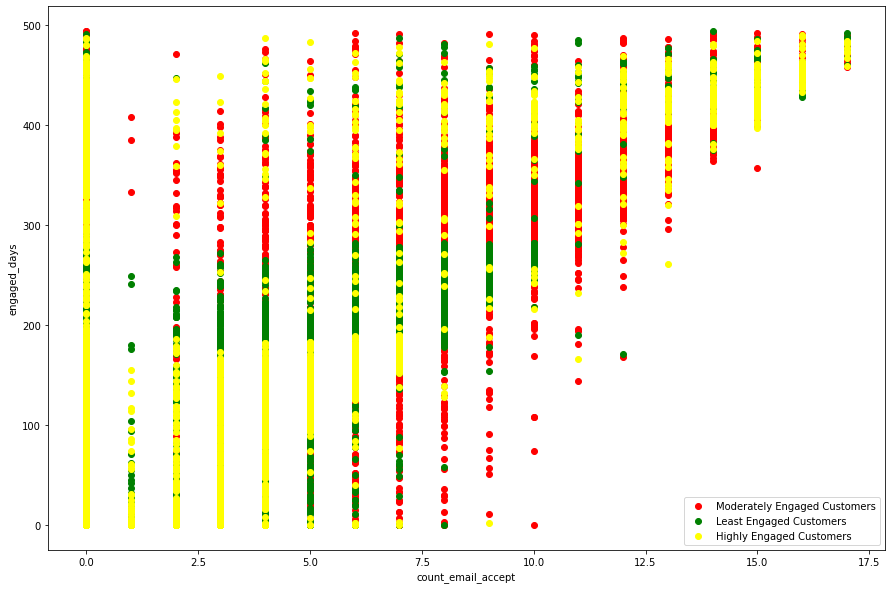

In [ ]:
plt.figure(figsize = (15, 10))
plt.scatter(part5["count_email_accept"][part5["h_type"] == 0], part5["engaged_days"][part5["h_type"] == 0], color = "red", label = 'Moderately Engaged Customers')
plt.scatter(part5["count_email_accept"][part5["h_type"] == 1], part5["engaged_days"][part5["h_type"] == 1], color = "green", label = 'Least Engaged Customers')
plt.scatter(part5["count_email_accept"][part5["h_type"] == 2], part5["engaged_days"][part5["h_type"] == 2], color = "yellow", label = 'Highly Engaged Customers')
#plt.scatter(ak_centroids[:,0], ak_centroids[:,1], color = 'black')
plt.xlabel('count_email_accept')
plt.ylabel('engaged_days')
plt.legend()
plt.show()

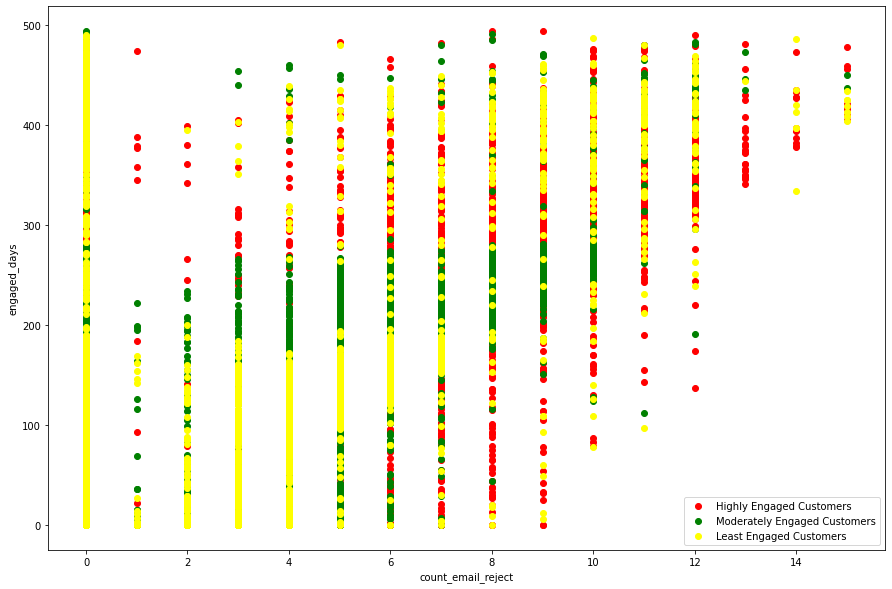

In [ ]:
plt.figure(figsize = (15, 10))
plt.scatter(part5["count_email_reject"][part5["h_type"] == 0], part5["engaged_days"][part5["h_type"] == 0], color = "red", label = 'Highly Engaged Customers')
plt.scatter(part5["count_email_reject"][part5["h_type"] == 1], part5["engaged_days"][part5["h_type"] == 1], color = "green", label = 'Moderately Engaged Customers')
plt.scatter(part5["count_email_reject"][part5["h_type"] == 2], part5["engaged_days"][part5["h_type"] == 2], color = "yellow", label = 'Least Engaged Customers')
#plt.scatter(ak_centroids[:,0], ak_centroids[:,1], color = 'black')
plt.xlabel('count_email_reject')
plt.ylabel('engaged_days')
plt.legend()
plt.show()

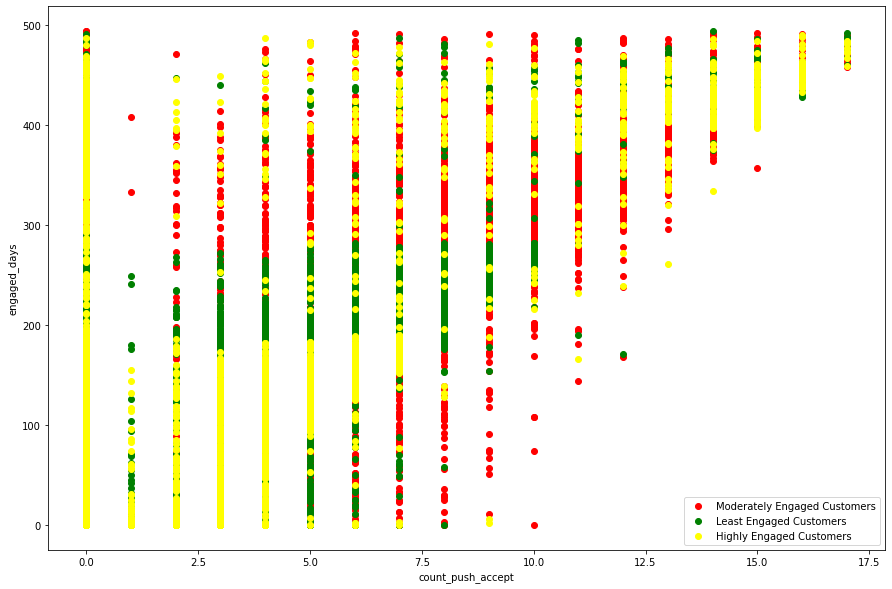

In [ ]:
plt.figure(figsize = (15, 10))
plt.scatter(part5["count_push_accept"][part5["h_type"] == 0], part5["engaged_days"][part5["h_type"] == 0], color = "red", label = 'Moderately Engaged Customers')
plt.scatter(part5["count_push_accept"][part5["h_type"] == 1], part5["engaged_days"][part5["h_type"] == 1], color = "green", label = 'Least Engaged Customers')
plt.scatter(part5["count_push_accept"][part5["h_type"] == 2], part5["engaged_days"][part5["h_type"] == 2], color = "yellow", label = 'Highly Engaged Customers')
#plt.scatter(ak_centroids[:,0], ak_centroids[:,1], color = 'black')
plt.xlabel('count_push_accept')
plt.ylabel('engaged_days')
plt.legend()
plt.show()

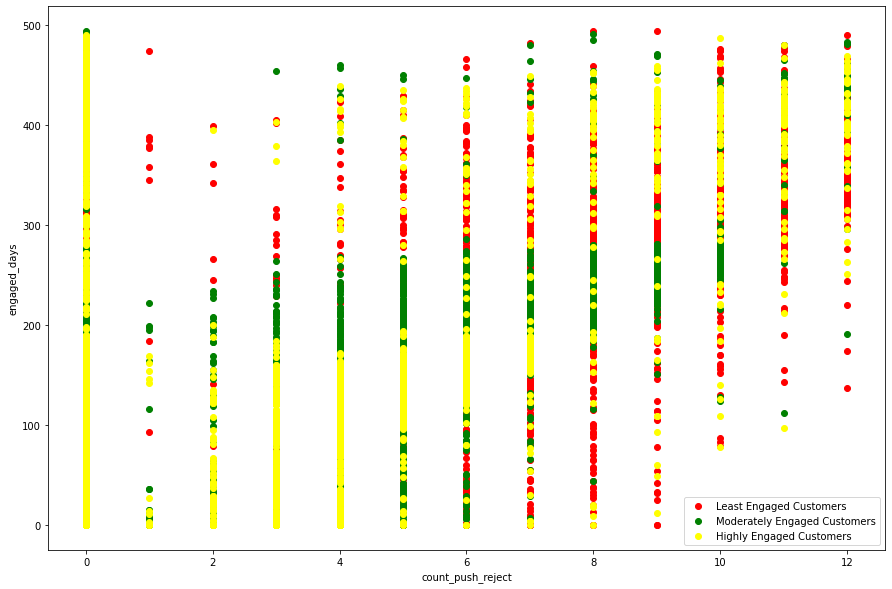

In [ ]:
plt.figure(figsize = (15, 10))
plt.scatter(part5["count_push_reject"][part5["h_type"] == 0], part5["engaged_days"][part5["h_type"] == 0], color = "red", label = 'Least Engaged Customers')
plt.scatter(part5["count_push_reject"][part5["h_type"] == 1], part5["engaged_days"][part5["h_type"] == 1], color = "green", label = 'Moderately Engaged Customers')
plt.scatter(part5["count_push_reject"][part5["h_type"] == 2], part5["engaged_days"][part5["h_type"] == 2], color = "yellow", label = 'Highly Engaged Customers')
#plt.scatter(ak_centroids[:,0], ak_centroids[:,1], color = 'black')
plt.xlabel('count_push_reject')
plt.ylabel('engaged_days')
plt.legend()
plt.show()

We can see in the above diagram that clustering of customers is almost similar to what was done by K-Means clustering. Only the cluster positions has changed for differentiating both the clustering diagrams. 

Cluster 3 is the cluster of highly engaged customer and Cluster 1 is the cluster of least engaged customer.



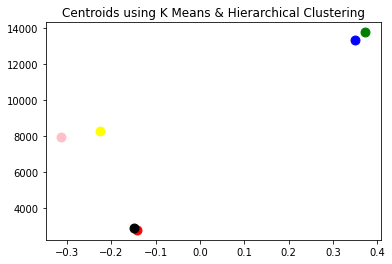

In [ ]:
color=['red', 'green', 'yellow']
color1=['blue', 'black', 'pink']
for i in range(3):
  plt.scatter(sk_centroids[i,0] , sk_centroids[i,1] , s = 80, color = color[i])  
  plt.scatter(ak_centroids[i,0] , ak_centroids[i,1] , s = 80, color = color1[i])
plt.title('Centroids using K Means & Hierarchical Clustering')  
plt.show()

The centroids of clusters changes between kmeans and hierarchical clustering. Cluster 1, 2 consists of engaged customers and Cluster 3 consists of un-engaged customers.